## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [4]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [5]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

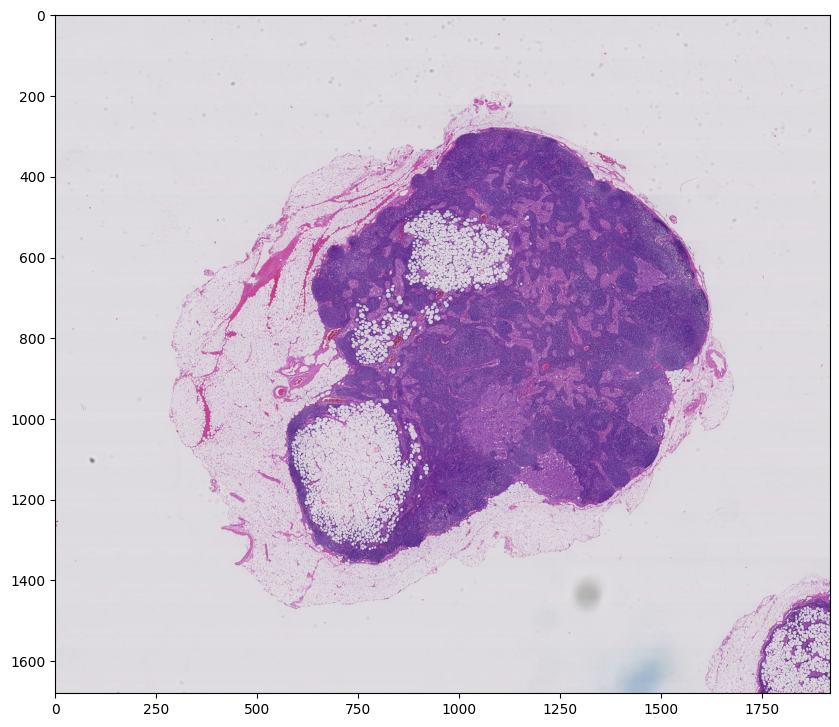

In [6]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

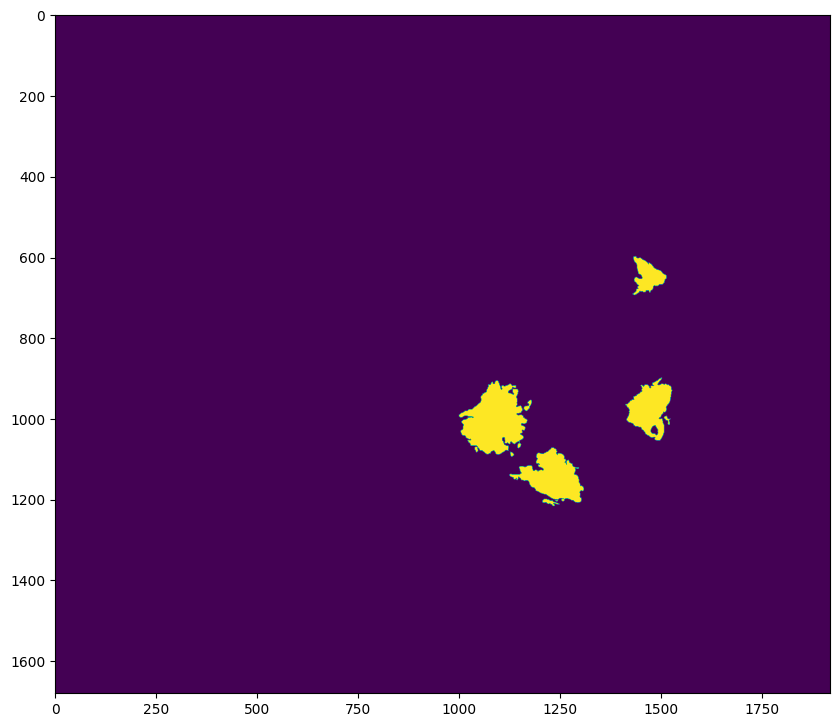

In [7]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

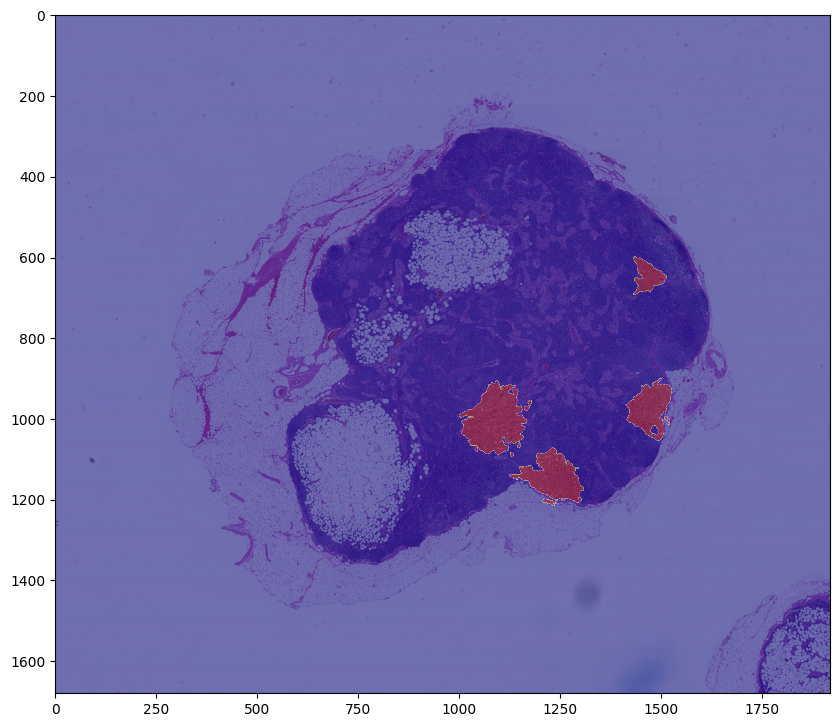

In [8]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

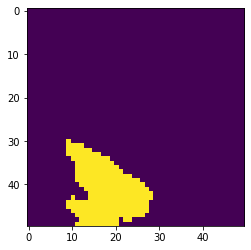

In [9]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


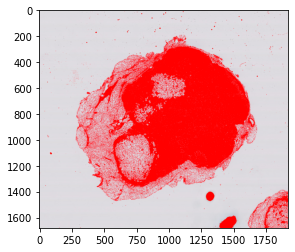

In [10]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
from PIL import Image
from os import makedirs
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [13]:
IMG_SLIDE_DIM = 299
IMG_SLIDE_DIM_CENTER = 128

def make_folders_for_level(level, is_test):
  folder_struct = ''
  if is_test:
    folder_struct = 'level-{}-test/healthy'.format(level)
  else:
    folder_struct = 'level-{}/healthy'.format(level)
  makedirs(folder_struct)
  if is_test:
    folder_struct = 'level-{}-test/tumor/'.format(level)
  else:
    folder_struct = 'level-{}/tumor/'.format(level)
  makedirs(folder_struct)
  if is_test:
    folder_struct = 'level-{}-test-masks/masks/'.format(level)
  else:
    folder_struct = 'level-{}-masks/masks/'.format(level)
  makedirs(folder_struct)

def getSlicePath(level, label, slide_path, x, y, is_test):
  slice_image_name_prefix = ''
  if is_test:
    slice_image_name_prefix = 'level-{}-test/{}/{}-x-{}-y-{}.png' 
  else:
    slice_image_name_prefix = 'level-{}/{}/{}-x-{}-y-{}.png' 
  return slice_image_name_prefix.format(level, label, slide_path.split(".")[0], x, y)

def getMaskSlicePath(level, slide_path, x, y, is_test):
  slice_image_name_prefix = ''
  if is_test:
    slice_image_name_prefix = 'level-{}-test-masks/masks/{}-x-{}-y-{}.png'
  else:
    slice_image_name_prefix = 'level-{}-masks/masks/{}-x-{}-y-{}.png'
  return slice_image_name_prefix.format(level, slide_path.split(".")[0], x, y)

def process_slide(base_path, 
                  slide_path, 
                  level, 
                  threshold_tissue_percentage, 
                  sliding_window_div, # The larger this value, the more patches
                  is_test):
  tumor_mask_path = slide_path.split(".")[0] + "_mask.tif"
  slide = open_slide(base_path + slide_path)
  tumor_mask = open_slide(base_path + tumor_mask_path)

  level_slide_width = slide.level_dimensions[level][0]
  level_slide_height = slide.level_dimensions[level][1]

  horizontal_slices_count = level_slide_width - IMG_SLIDE_DIM
  vertical_slices_count = level_slide_height - IMG_SLIDE_DIM
  horizontal_sliding_window = level_slide_width // sliding_window_div
  vertical_sliding_window = level_slide_height // sliding_window_div

  offset_center_mask_slice = 85 # (299-128)/2
  i = j = 0
  while (j < vertical_slices_count):
    i = 0
    while (i < horizontal_slices_count):
      x = i*2**level
      y = j*2**level
      normal_slice_image = read_slide(slide, x=x, y=y, 
                                      level=level, 
                                      width=IMG_SLIDE_DIM, 
                                      height=IMG_SLIDE_DIM)
      mask_slice_image = read_slide(tumor_mask, x=x, y=y, 
                                    level=level, 
                                    width=IMG_SLIDE_DIM, 
                                    height=IMG_SLIDE_DIM)
      mask_slice_image = mask_slice_image[:,:,0]
      mask_slice_image_center = read_slide(tumor_mask, 
                                           x=x+offset_center_mask_slice, 
                                           y=y+offset_center_mask_slice, 
                                           level=level, 
                                           width=IMG_SLIDE_DIM_CENTER, 
                                           height=IMG_SLIDE_DIM_CENTER)
      mask_slice_image_center = mask_slice_image_center[:,:,0]
      mask_tissue_pixels = find_tissue_pixels(mask_slice_image_center)
      mask_percent_tissue = 100 - len(mask_tissue_pixels) / float(IMG_SLIDE_DIM_CENTER * IMG_SLIDE_DIM_CENTER) * 100

      tissue_pixels = find_tissue_pixels(normal_slice_image)
      percent_tissue = len(tissue_pixels) / float(IMG_SLIDE_DIM * IMG_SLIDE_DIM) * 100
      if (percent_tissue > threshold_tissue_percentage):
        if (mask_percent_tissue > 1):
          # Save as tumor
          im = Image.fromarray(normal_slice_image)
          im.save(getSlicePath(level, 'tumor', slide_path, x, y, is_test))
          im = Image.fromarray(mask_slice_image)
          im.save(getMaskSlicePath(level, slide_path, x, y, is_test))
        else:
          # Save as healthy
          im = Image.fromarray(normal_slice_image)
          im.save(getSlicePath(level, 'healthy', slide_path, x, y, is_test))
      i += horizontal_sliding_window
    j += vertical_sliding_window

In [14]:
def build_dataset(path, level):
  threshold_tissue_percentage = 10
  sliding_window_div = 40 # the lower this number, the fewer slices
  batch_size = 32
  seed = 0

  train_dir = '/content/level-{}/'.format(level)
  train_masks_dir = '/content/level-{}-masks/'.format(level)

  files = [f for f in listdir(path) if isfile(join(path, f))]
  for file in files:
    if "mask" not in file: 
      try:
        make_folders_for_level(level, False)
      except:
        print('...') # Do nothing. This try/catch is to prevent exceptions being 
                    # thrown when the folders already exist
      process_slide(path, file, level, threshold_tissue_percentage, sliding_window_div, False)

  train_ds = preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.3,
    image_size = (IMG_SLIDE_DIM, IMG_SLIDE_DIM),
    subset='training',
    seed=seed)

  val_ds = preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.3,
    image_size = (IMG_SLIDE_DIM, IMG_SLIDE_DIM),
    subset='validation',
    seed=seed)

  class_names = train_ds.class_names
  print(class_names)

  # Sanity check - displaying images from slides (299x299)
  plt.figure(figsize=(12, 12))
  batch_index = 1
  for images, labels in train_ds.take(batch_index):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

  return train_ds, val_ds

...
...
...
...
...
...
...
Found 2830 files belonging to 2 classes.
Using 1981 files for training.
Found 2830 files belonging to 2 classes.
Using 849 files for validation.
['healthy', 'tumor']
[-2.88999883]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 88,912,673
Trainable params: 6

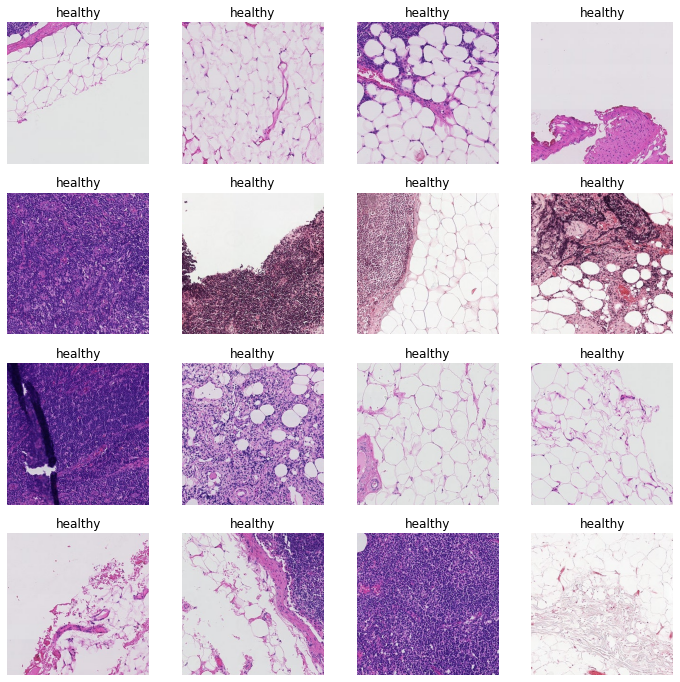

In [15]:
LEVEL = 3
TRAINING_DATA_PATH = "/content/gdrive/MyDrive/COMS4995-data/"

train_ds, val_ds = build_dataset(TRAINING_DATA_PATH, LEVEL)

healthy_train_dir = '/content/level-{}/healthy'.format(LEVEL)
healthy_files = [f for f in listdir(healthy_train_dir) if isfile(join(healthy_train_dir, f))]
neg = len(healthy_files)

tumor_train_dir = '/content/level-{}/tumor'.format(LEVEL)
tumor_files = [f for f in listdir(tumor_train_dir) if isfile(join(tumor_train_dir, f))]
pos = len(tumor_files)

initial_bias = np.log([pos/neg])
print(initial_bias)

# Improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_SLIDE_DIM, IMG_SLIDE_DIM, 3)),
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(IMG_SLIDE_DIM, IMG_SLIDE_DIM, 3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
  ]
)

# creating the model 
output_bias = tf.keras.initializers.Constant(initial_bias)
conv_base = tf.keras.applications.InceptionV3(weights='imagenet',
                  include_top=False, input_shape = (IMG_SLIDE_DIM, IMG_SLIDE_DIM, 3))
model = tf.keras.models.Sequential()
model.add(data_augmentation)
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

# Re-train model
conv_base.trainable = False
model.summary()

model.compile(loss='binary_crossentropy',
             optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
             metrics = ['acc'])

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


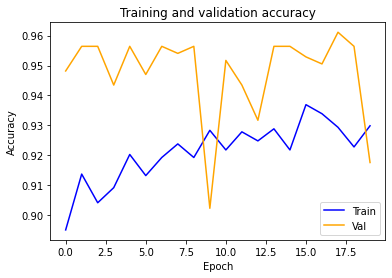

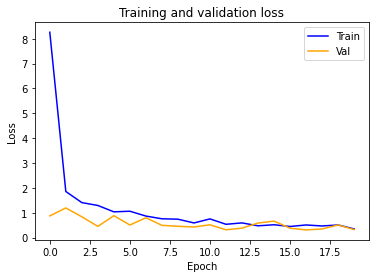

In [16]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()
  
plot(history)

In [17]:
best_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=best_epochs)

Epoch 1/10
62/62 [==============================] - 7s 121ms/step - loss: 0.4393 - acc: 0.9319 - val_loss: 0.4187 - val_acc: 0.9564
Epoch 2/10
62/62 [==============================] - 7s 121ms/step - loss: 0.4291 - acc: 0.9273 - val_loss: 0.3388 - val_acc: 0.9458
Epoch 3/10
62/62 [==============================] - 7s 121ms/step - loss: 0.3519 - acc: 0.9404 - val_loss: 0.3356 - val_acc: 0.9470
Epoch 4/10
62/62 [==============================] - 7s 120ms/step - loss: 0.3794 - acc: 0.9334 - val_loss: 0.2658 - val_acc: 0.9234
Epoch 5/10
62/62 [==============================] - 7s 121ms/step - loss: 0.3104 - acc: 0.9313 - val_loss: 0.7067 - val_acc: 0.9576
Epoch 6/10
62/62 [==============================] - 7s 121ms/step - loss: 0.3379 - acc: 0.9364 - val_loss: 0.3616 - val_acc: 0.8975
Epoch 7/10
62/62 [==============================] - 7s 120ms/step - loss: 0.2864 - acc: 0.9374 - val_loss: 0.4096 - val_acc: 0.9541
Epoch 8/10
62/62 [==============================] - 7s 120ms/step - loss: 0.

In [18]:
DPI = 100
FIGSIZE = 500

def validate_heatmap(path, level):
  files = [f for f in listdir(path) if isfile(join(path, f))]
  for file in files:
    if "mask" not in file: 
      slide_path = file
      print("Slide path:")
      print(slide_path)
      slide = open_slide(path + slide_path)
      slide_image = read_slide(slide, x=0, y=0, level=level,
                              width=slide.level_dimensions[level][0], 
                              height=slide.level_dimensions[level][1])
      tumor_mask_path = slide_path.split(".")[0] + "_mask.tif"
      tumor_mask = open_slide(path + tumor_mask_path)
      mask_image = read_slide(tumor_mask, x=0, y=0, level=level, 
                          width=slide.level_dimensions[level][0], 
                          height=slide.level_dimensions[level][1])
      mask_image = mask_image[:,:,0]
      plt.figure(figsize=(FIGSIZE/DPI, FIGSIZE/DPI), dpi=DPI)
      plt.imshow(slide_image)
      plt.imshow(mask_image, cmap='jet', alpha=0.7) # Red regions contains cancer.
      plt.show()

      plt.figure(figsize=(FIGSIZE/DPI, FIGSIZE/DPI), dpi=DPI)
      ax = plt.gca()
      plt.imshow(slide_image)
      tumors_path = '/content/level-{}/tumor'.format(level)
      tumor_files = [f for f in listdir(tumors_path) if isfile(join(tumors_path, f))]
      for tumor_file in tumor_files:
        if (slide_path.split('.')[0] in tumor_file):
          tumor_file_parts = tumor_file.split('-')
          x_coord = int(tumor_file_parts[2]) / 2**level
          y_coord = int(tumor_file_parts[4].split('.')[0]) / 2**level
          rect = patches.Rectangle((x_coord, y_coord), IMG_SLIDE_DIM, IMG_SLIDE_DIM, color = 'r', fill = True)
          ax.add_patch(rect)
      plt.show()

#validate_heatmap(TRAINING_DATA_PATH, LEVEL)

...
...
Slide path:
tumor_094.tif


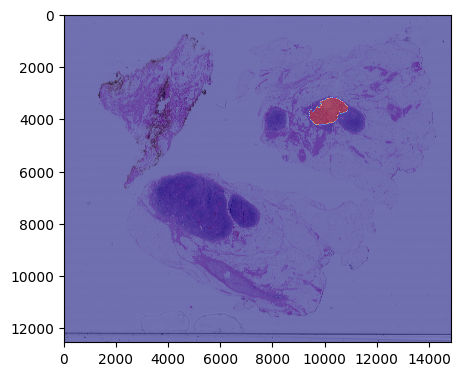

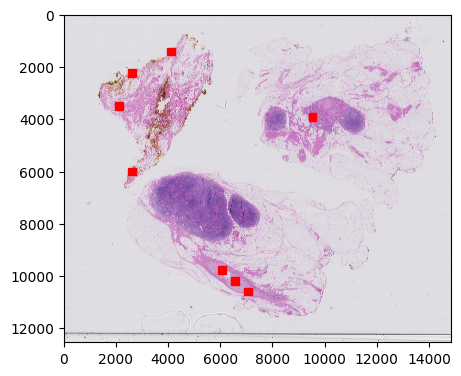

Slide path:
tumor_078.tif


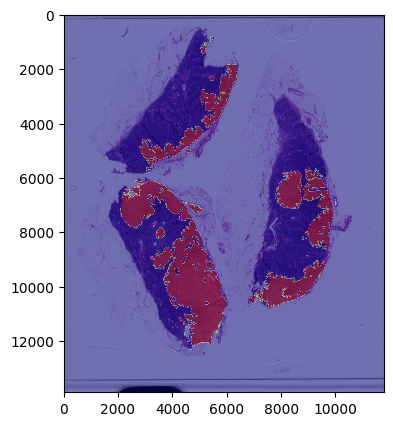

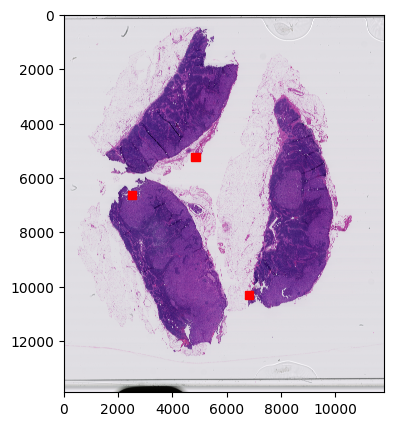

TN, TP, FN, FP:
3 644 159 8
Accuracy:
0.7948402948402948


In [19]:
TESTING_DATA_PATH = "/content/gdrive/MyDrive/COMS4995-data-test/"
DPI = 100
FIGSIZE = 500

def build_test_dataset(path, level):
  threshold_tissue_percentage = 10
  sliding_window_div = 30 # the lower this number, the fewer slices
  files = [f for f in listdir(path) if isfile(join(path, f))]
  for file in files:
    if "mask" not in file: 
      try:
        make_folders_for_level(level, True)
      except:
        print("...") # Do nothing
      process_slide(path, file, level, threshold_tissue_percentage, sliding_window_div, True)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SLIDE_DIM, IMG_SLIDE_DIM))
    return img

def predict_and_build_heatmap(path):
  files = [f for f in listdir(path) if isfile(join(path, f))]
  TP = 0
  FP = 0
  TN = 0
  FN = 0
  for file in files:
    if "mask" not in file: 
      slide_path = file
      print("Slide path:")
      print(slide_path)
      slide = open_slide(path + slide_path)
      slide_image = read_slide(slide, x=0, y=0, level=LEVEL,
                              width=slide.level_dimensions[LEVEL][0], 
                              height=slide.level_dimensions[LEVEL][1])
      tumor_mask_path = slide_path.split(".")[0] + "_mask.tif"
      tumor_mask = open_slide(path + tumor_mask_path)
      mask_image = read_slide(tumor_mask, x=0, y=0, level=LEVEL, 
                          width=slide.level_dimensions[LEVEL][0], 
                          height=slide.level_dimensions[LEVEL][1])
      mask_image = mask_image[:,:,0]
      plt.figure(figsize=(FIGSIZE/DPI, FIGSIZE/DPI), dpi=DPI)
      plt.imshow(slide_image)
      plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
      plt.show()

      plt.figure(figsize=(FIGSIZE/DPI, FIGSIZE/DPI), dpi=DPI)
      ax = plt.gca()
      plt.imshow(slide_image)
      test_image_paths = ['/content/level-{}-test/tumor'.format(LEVEL),
               '/content/level-{}-test/healthy'.format(LEVEL)]

      for curr_path in test_image_paths:
        curr_files = [f for f in listdir(curr_path) if isfile(join(curr_path, f))]
        label = ''
        if 'healthy' in curr_path:
          true_label = 'healthy'
        else:
          true_label = 'tumor'
        for curr_file in curr_files:
          if (slide_path.split('.')[0] in curr_file):
            try:
              x = load_image(curr_path + '/' + curr_file)
              x = np.expand_dims(x, axis=0)
              prediction = model.predict(x)
              predicted_label = 'healthy'
              #print(curr_path)
              #print(prediction[0])
              if (prediction[0] > 0.5):
                predicted_label = 'tumor'
                #print(curr_path)
                #print(prediction[0])
                file_parts = curr_file.split('-')
                x_coord = int(file_parts[2]) / 2**LEVEL
                y_coord = int(file_parts[4].split('.')[0]) / 2**LEVEL
                rect = patches.Rectangle((x_coord, y_coord), IMG_SLIDE_DIM, 
                                         IMG_SLIDE_DIM, color = 'r', fill = True)
                ax.add_patch(rect)
              if (true_label == predicted_label):
                if predicted_label == 'healthy':
                  TP += 1
                else:
                  TN += 1
              else:
                if predicted_label == 'healthy':
                  FN += 1
                else:
                  FP += 1
            except:
              continue
      plt.show()
  return TN, TP, FN, FP

build_test_dataset(TESTING_DATA_PATH, LEVEL)
TN, TP, FN, FP = predict_and_build_heatmap(TESTING_DATA_PATH)
print("TN, TP, FN, FP:")
print(TN, TP, FN, FP)
print("Accuracy:")
print((TN + TP) / (TN + TP + FN + FP))
